<a href="https://colab.research.google.com/github/phfgomes1969/PUC-RJ-MVP/blob/main/MVP_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Objetivo deste Estudo***


Interpretar as informações de uma seguradora e responder questões


Qual o meu faturamento Mensal ?

Qual o produto (ramo) mais vendido ?

A quantidade de sinistros pagos e a sinistralidade

As conclusões/análises estão do "Relatório Análise Seguradora.doc', disponibilizado no mesmo endereço do GitHub

In [1]:
import pandas as pd
from datetime import date

# importação do Seaborn
import seaborn as sns

# importação do pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import zipfile
import requests


**Área de Leitura de Arquivos**

In [2]:
# Baixa os Arquivos que estão no GiutHub

prefixo_url = 'https://github.com/phfgomes1969/PUC-RJ-MVP/raw/main/'

nomes_arquivos = ['RAMOS.zip', 'DADOS_GERAIS.zip', 'DADOS_FATURAS.zip' ,'SIN_PGTO.zip']

for nome in nomes_arquivos:
  !wget -q {prefixo_url + nome} -O {nome}
  with zipfile.ZipFile(nome, 'r') as zip_ref:
    zip_ref.extractall('.')

**Leitura dos Arquivos**

In [3]:
df_dg = pd.read_csv('DADOS_GERAIS.csv', sep=';', encoding='latin-1')
df_ft = pd.read_csv('DADOS_FATURAS.csv', sep=';', encoding='latin-1')
df_ramos = pd.read_csv('RAMOS.csv', sep=';', encoding='latin-1')
df_sin   = pd.read_csv('SIN_PGTO.csv', sep=';', encoding='latin-1')


# Deleto as colunas que Não preciso do Frame Ramos
df_ramos = df_ramos.drop(['NOM_RM','TIP_GRP_RM'], axis=1)

**Análise dos Dados**

*As informações extraídas são repassadas para o "Relatório Análise Seguradora.doc"*

In [4]:
# Quantidade de Linhas e Colunas
nomes_arquivos = ['DADOS_GERAIS.csv', 'DADOS_FATURAS.csv', 'RAMOS.csv', 'SIN_PGTO.csv']
dfs = [df_dg, df_ft, df_ramos, df_sin]

for i, nome in enumerate(nomes_arquivos):
  print(f'{nome}: {dfs[i].shape}')

DADOS_GERAIS.csv: (31289, 118)
DADOS_FATURAS.csv: (1811, 67)
RAMOS.csv: (95, 2)
SIN_PGTO.csv: (4887, 18)


In [5]:
# Descrição dos campos de cada um dos arquivos (Informações adiciomnadas ao relatório)
for i, nome in enumerate(nomes_arquivos):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
      print(f'{nome}:\n{dfs[i].dtypes}')
      print('\n')




DADOS_GERAIS.csv:
NUM_DE                     int64
NUM_EMP                    int64
NUM_SUC                    int64
COD_DOC                   object
COD_DOC_ORIG              object
COD_DOC_RENOV             object
NUM_SEGUR_ANT            float64
COD_DOC_ENDO              object
COD_DOC_CANC              object
TIP_MOT_ENDO              object
NUM_RM                     int64
NUM_SUB_RM                 int64
NUM_PRDT                   int64
COD_INTV                  object
NUM_PRDT_COR             float64
NUM_PES_SEG                int64
SEXO                      object
NOM_PES_SEG               object
DT_NASC_FUND              object
SEQ_END_RESID              int64
SEQ_END_CORR               int64
DSC_END                   object
NUM_END                    int64
DSC_END_CPL               object
COD_CEP                    int64
DT_RECE                   object
TIP_DOC                   object
STA_DOC                   object
DT_VIG_INI                object
DT_VIG_FIM               

In [6]:
# Verificando as primeiras linhas de cada um dos arquivos

for i, nome in enumerate(nomes_arquivos):
  print(f'{nome}:\n{dfs[i].head()}')
  print('\n')

DADOS_GERAIS.csv:
   NUM_DE  NUM_EMP  NUM_SUC              COD_DOC         COD_DOC_ORIG  \
0  152802        1        1  0101.82.01.00011036  0101.82.00.00005438   
1  168932        1        1  0101.93.01.00011756  0101.93.00.00011390   
2  177708        1        1  0101.82.01.00006038  0101.71.00.00016368   
3  177903        1        1  0101.82.01.00004696  0101.82.00.00009350   
4  178101        1        1  0101.93.00.00013453  0101.93.00.00013453   

         COD_DOC_RENOV  NUM_SEGUR_ANT         COD_DOC_ENDO  \
0                  NaN            NaN  0101.82.00.00005438   
1            311901619         5177.0  0101.93.00.00011390   
2                  NaN            NaN  0101.71.00.00016368   
3                  NaN            NaN  0101.82.00.00009350   
4  0101.53.00.00006142         2119.0                  NaN   

          COD_DOC_CANC TIP_MOT_ENDO  ...  TIP_ENVIO_DOC  TIP_DST_DOC  \
0                  NaN            I  ...          EMAIL          COR   
1  0101.93.01.00014314    

**Ajustes e Padronizações de campos**

In [7]:
#Inserindo uma nova coluna no dataframe df_dg, já que a mesma
# não existe no CSV Original
df_dg.insert(2, 'AM_COMP', 0)

In [8]:
# Inserindo uma nova coluna no dataframe df_ft, já que a mesma
# não existe no CSV original
df_ft.insert(2, 'NUM_RM', 0)
df_ft.insert(3,'SEXO','X')

In [9]:
# Identificação do Ramo (NUM_RM) dos casos em que NUM_RM está zerado

# Encontro NUM_RM (Ramo de Seguro) para df_ft
df_ft['NUM_RM'] = df_ft['COD_DOC'].apply(lambda x: x[5:7])

df_dg['NUM_RM'] = df_dg['COD_DOC'].apply(lambda x: x[5:7])



In [10]:
# Selecionando apenas as colunas de interesse

colunas_selecionadas =  [ 'NUM_DE', 'AM_COMP', 'VLR_PRE_TOT', 'DT_EMISS',
                         'COD_TIP_DE', 'NUM_RM', 'STA_DOC', 'DT_NASC_FUND','SEXO']


# Criando dataframes auxiliares antes da junção final
df_dg_aux = df_dg[colunas_selecionadas]

# Tabela Faturas Não tem a data de nascimento. Por isso adiciono os campos e depois adiciono o DT_NASC_FUND = 0
colunas_selecionadas =  [ 'NUM_DE', 'AM_COMP', 'VLR_PRE_TOT', 'DT_EMISS', 'COD_TIP_DE', 'NUM_RM']

df_ft_aux = df_ft[colunas_selecionadas]

# Adiciono o campo DT_NASC_FUND

df_ft_aux.insert(2, 'DT_NASC_FUND', 0)


In [11]:
# Ajustando o campo DT_EMISS para ficar no padrão
df_dg_aux.loc[:,'DT_EMISS'] = pd.to_datetime(df_dg_aux['DT_EMISS'], errors='coerce', dayfirst=True)

df_sin['DT_PGTO'] = pd.to_datetime(df_sin['DT_PGTO'])


In [12]:
# Junção dos dataframes auxiliares criados
df = pd.concat([df_dg_aux, df_ft_aux])


In [13]:
# Limpo dataset de valores cujo NUM_DE = NULL
df = df.dropna(subset=['NUM_DE'])

In [14]:
#Ajusto o campo DT_EMISS de todo frame

df['DT_EMISS'] = pd.to_datetime(df['DT_EMISS'])

In [15]:
# Ajusto o campo NUM_RM em todo frame
df['NUM_RM'] = df['NUM_RM'].astype(str)

In [16]:
# Alterando o formato do campo VLR_PRE_TOT ( Valor Prêmio Total ) para NUMERIC
# Foi identificado que alguns valores estão em notações diferentes
# Exemplo:
#    Alguns valores estão como 1250,45, outros estão como 1250.45

# Antes, converto os valores em STR para todo dataframe
df['VLR_PRE_TOT'] = df['VLR_PRE_TOT'].astype(str)

# Faço isso para Sinistros também
df_sin['VLR_PGTO'] = df_sin['VLR_PGTO'].astype(str)

# substituo os valores caso algum dos itens esteja com ',' oa inves de '.'
substituir_virgula = lambda x: x.replace(',', '.') if ',' in x else x

# Aplica a função à coluna VLR_PRE_TOT
df['VLR_PRE_TOT'] = df['VLR_PRE_TOT'].apply(substituir_virgula)

df_sin['VLR_PGTO'] = df_sin['VLR_PGTO'].apply(substituir_virgula)


In [17]:
# Volto a informação para Valor Numérico
df['VLR_PRE_TOT'] = pd.to_numeric(df['VLR_PRE_TOT'], errors='coerce')

df_sin['VLR_PGTO'] = pd.to_numeric(df_sin['VLR_PGTO'], errors='coerce')


In [18]:
# Dentro do DataFrame df, a coluna AM_COMP (competência) não está carregada para
# todos os registros
# Sendo assim, dividi o frame df em 2 para fazer o tratamento.
# Um com AM_COMP preenchido e Outro com AM_COMP = 0

df_filtrado_comp0    =  df[df['AM_COMP'] == 0]
df_filtrado_compdif0 =  df[df['AM_COMP'] != 0]

# Frame de Sinistros não tem AM_COMP. Criando...
df_sin.insert(2, 'AM_COMP', 0)



In [19]:
# Para os casos onde AM_COMP = 0, considero a data de emissão para formatar
# o AM_COMP (Competência)

df_filtrado_comp0.loc[:, 'AM_COMP'] = (df_filtrado_comp0['DT_EMISS'].dt.year* 100 +
                                      df_filtrado_comp0['DT_EMISS'].dt.month).astype(str)

df_sin.loc[:, 'AM_COMP'] = (df_sin['DT_PGTO'].dt.year* 100 +
                           df_sin['DT_PGTO'].dt.month).astype(str)


In [20]:
# Para os casos onde AM_COMP <> 0
# Para estes casos, considero a própria informação que está em AM_COMP e atualizo para String
df_filtrado_compdif0.loc[:, 'AM_COMP'] = (df_filtrado_compdif0['AM_COMP']).astype(str)


In [21]:
# Concateno os dois frames
df = pd.concat([df_filtrado_comp0, df_filtrado_compdif0])

In [22]:
# Criação do campo ANO, onde a rotina irá identificar o Ano pela AM_COMP
df['ANO'] = df['AM_COMP'].apply(lambda x: x[:4])


In [23]:
# Inclusão do ABV Ramos no DataFrame

df['NUM_RM'] = pd.to_numeric(df['NUM_RM'], errors='coerce')

df = pd.merge(df, df_ramos, on='NUM_RM', how='left')



In [24]:
df['ABV_RM'] = df.apply(lambda row: str(row['NUM_RM']) + '-' + row['ABV_RM'], axis=1)

In [25]:
# Capturando registros do TIP_DE = 'PP'(Propostas) ou 'FT' (Faturas) ou
#'E1' (Endosso de Cobrança)
# Os demais são descartados porque são endossos e não possuem Valores

#propostas
df_pp =  df[df['COD_TIP_DE'] == 'PP']

#faturas
df_ft =  df[df['COD_TIP_DE'] == 'FT']

#endossos de cobrança
df_E1 =  df[df['COD_TIP_DE'] == 'E1']

#endossos de cancelamento
df_E5 =  df[df['COD_TIP_DE'] == 'E5']

In [26]:
# Concateno os 3 frames em um novo frame (df_pp_ft)
df_pp_ft = pd.concat([df_pp, df_ft, df_E1])

In [27]:
# Calculo a Idade dos segurados

# Ajusto DT_NASC_FUND
df_pp_ft['DT_NASC_FUND'] = pd.to_datetime(df_pp_ft['DT_NASC_FUND'], errors='coerce')

# Caso a coluna DT_NASC_FUND é NULA
df_pp_ft['DT_NASC_FUND'] = pd.to_datetime(df_pp_ft['DT_NASC_FUND'].fillna('01-01-1900'))

# Calcular idade
def calc_idade(data_nasc):
    dt_hoje = date.today()
    return dt_hoje.year - data_nasc.year - ((dt_hoje.month, dt_hoje.day) < (data_nasc.month, data_nasc.day))

# Calcula a idade
df_pp_ft['IDADE'] = df_pp_ft['DT_NASC_FUND'].apply(calc_idade)



In [28]:
# Discretização da Faixa Etária para posteriormente aplicar o One-Hot Enconding

# Defina os intervalos de idade
bins = [0, 18, 40, 60, 80, 150]
labels = ['<18', '18-40', '41-60', '61-80', '>80']

# Crie uma nova coluna com os intervalos de idade
df_pp_ft['FAIXA_ETARIA'] = pd.cut(df_pp_ft['IDADE'], bins=bins, labels=labels, right=False)

# Aplique one-hot encoding
df_pp_ft = pd.get_dummies(df_pp_ft, columns=['FAIXA_ETARIA'])

**Área das variáveis que serão usadas nos gráficos**

In [76]:
# Gráfico de total de Prêmios Emitidos no ano correspondente
Vlr_Pre_totXAno = df_pp_ft.groupby('ANO')['VLR_PRE_TOT'].sum()


# Gráfico de PREMIO X AM_COMP
#Agrupo Valor de Prêmio Total (VLR_PRE_TOT) por competência (AM_COMP)
Vlr_Pre_totXComp = df_pp_ft.groupby('AM_COMP')['VLR_PRE_TOT'].sum()


#------------------------------------------------------------------

# Gráfico PRÊMIO X RAMO
#Verifico o total de prêmio emitido por ramo
Vlr_Pre_totXRam = df_pp_ft.groupby('ABV_RM')['VLR_PRE_TOT'].sum()

#------------------------------------------------------------------
# Gráfico SINISTROS X Competência
Vlr_Pre_pagXComp = df_sin.groupby('AM_COMP')['VLR_PGTO'].sum()


#-----------------------------------------------------------------

# Gráfico PRÊMIO EMITIDOS X PRÊMIOS CANCELADOS X Sinistros Pagos
#Verifico o total prêmios cabncelados emitidos por CompetÊncia
Vlr_Pre_totXCanc = df_E5.groupby('AM_COMP')['VLR_PRE_TOT'].sum()

#------------------------------------------------------------------

# Criei um novo DataFrame para deixar Assimetricos o CANCELAMENTO e PREMIOS EMITIDOS
# MOTIVO: Nem toda Competência houve Cancelamento, o que gerava problema no eixo X do gráfico

df_emXCancXSin_aux1 = pd.DataFrame(Vlr_Pre_totXComp)
df_emXCancXSin_aux2 = pd.DataFrame(Vlr_Pre_totXCanc)
df_emXCancXSin_aux3 = pd.DataFrame(Vlr_Pre_pagXComp)

# Carrego a coluna VLR_PRE_TOT_CAN com os valores do dataframe df_E5

df_emXCancXSin = pd.merge(df_emXCancXSin_aux1, df_emXCancXSin_aux2, on='AM_COMP', how='left')
df_emXCancXSin = pd.merge(df_emXCancXSin, df_emXCancXSin_aux3, on='AM_COMP', how='left')

# Setar com 0 todos os valores NULOS
df_emXCancXSin.fillna(0, inplace=True)

#---------------------------------------------------------------------
# Gráfico PRÊMIO X SEXO
#Verifico o total de prêmio emitido por sexo
Vlr_Pre_totXSex = df_pp_ft.groupby('SEXO')['VLR_PRE_TOT'].sum()
#---------------------------------------------------------------------
# Formato o campo AM_COMP para AAAA/MM

Vlr_Pre_totXComp.index = [f"{r[:4]}/{r[4:]}" for r in Vlr_Pre_totXComp.index]
Vlr_Pre_pagXComp.index = [f"{r[:4]}/{r[4:]}" for r in Vlr_Pre_pagXComp.index]
Vlr_Pre_totXCanc.index = [f"{r[:4]}/{r[4:]}" for r in Vlr_Pre_totXCanc.index]
df_emXCancXSin.index = [f"{r[:4]}/{r[4:]}" for r in df_emXCancXSin.index]

**Área dos Relatórios**

In [67]:
# Variáveis Comuns em todos os relatórios

# Função para formatar os valores
def formatador_milhao(x, pos):
    return f'{x/1000000}M'

def formatador_financ(x):
    return f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')

# Defino as cores que serão padroes nos relatórios
# Personalizar de acordo com o cliente

cor_preenchimento = '#CCEECC'
cor_borda = '#ADD8E6'
cor_linha = '#4169E1'
cor_letra = '#000000'

# Cores usadas no Violin Plot
cor_base1 = '#CCEECC'
cor_base2 = '#ADD8E6'
cor_base3 = '#4169E1'

#Para Gráfico de Pizza
cores = [cor_base1, cor_base2, cor_base3]

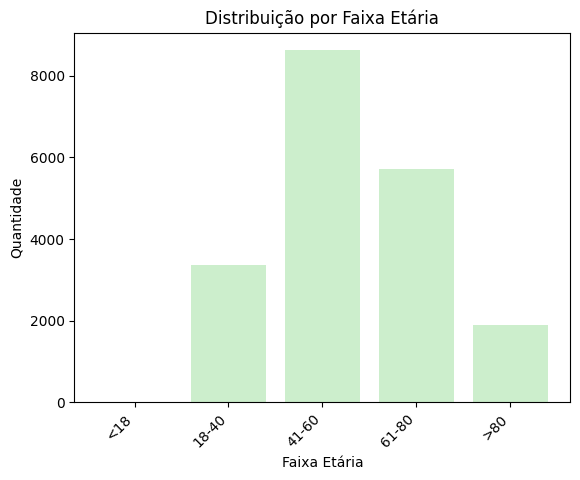

In [68]:
# Distribuição por Faixa Etária

# Lista com as novas colunas de faixa etária
faixa_etaria_cols = ['FAIXA_ETARIA_<18', 'FAIXA_ETARIA_18-40', 'FAIXA_ETARIA_41-60',
                     'FAIXA_ETARIA_61-80', 'FAIXA_ETARIA_>80']


# Seleciono apenas as Propostas
df_proposta = df_pp_ft[df_pp_ft['COD_TIP_DE'] == 'PP']

# Calcula a soma de cada faixa etária
totais = df_proposta[faixa_etaria_cols].sum()

totais.index = totais.index.str.replace('FAIXA_ETARIA_', '')
# Cria o gráfico de barras
plt.bar(totais.index, totais.values,color=cor_preenchimento)

# Define o título e os rótulos dos eixos
plt.title('Distribuição por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade')

# Rotaciona os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Exibe o gráfico
plt.show()

*Gráfico de Ticket Médio de Vendas por Ano*

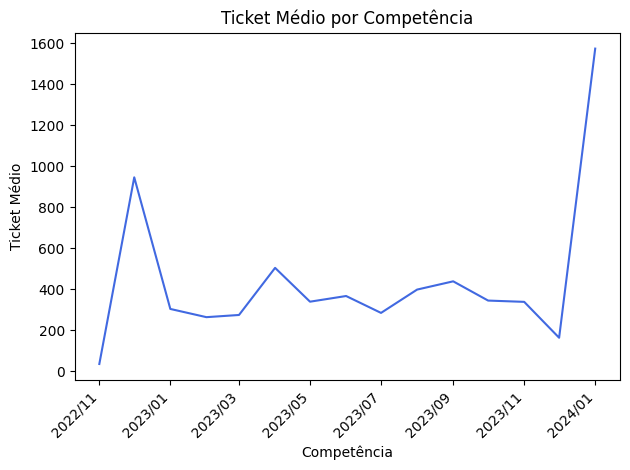

In [69]:
# Ticket Médio de Vendas
result = df_pp_ft.groupby('AM_COMP').agg({'AM_COMP': 'count', 'VLR_PRE_TOT': 'sum'})
result['Ticket Médio'] = (result['VLR_PRE_TOT']) / result['AM_COMP']


result.index = pd.to_datetime(result.index, format='%Y%m')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))


plt.plot(result.index, result['Ticket Médio'],color=cor_linha)
plt.xlabel('Competência')
plt.ylabel('Ticket Médio')
plt.title('Ticket Médio por Competência')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Gráfico Prêmios Emitidos durante o ano*

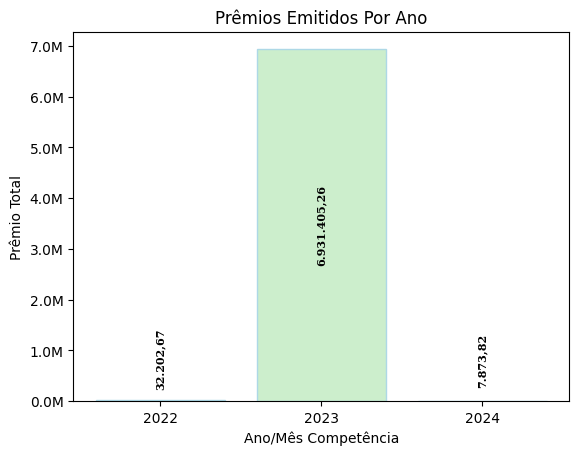

In [70]:
# Formata o eixo Y para mostrar valores em milhões
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatador_milhao))

# Plota o  gráfico de barras com os rótulos formatados
plt.bar(Vlr_Pre_totXAno.index, Vlr_Pre_totXAno.values, edgecolor=cor_borda, color=cor_preenchimento)

# Define o título e os rótulos dos eixos

# Configura o título e os rótulos dos eixos
plt.title('Prêmios Emitidos Por Ano')
plt.xlabel('Ano/Mês Competência')
plt.ylabel('Prêmio Total')


for i, v in enumerate(Vlr_Pre_totXAno.values):
  if v <= 5000000:
    offset = 800000
    plt.text(i, v+offset, formatador_financ(v), ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})
  else:
    plt.text(i, v/2, formatador_financ(v), ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})


# Exibe o gráfico
plt.show()

*Gráfico PRÊMIO EMITIDOS X AM Competência*

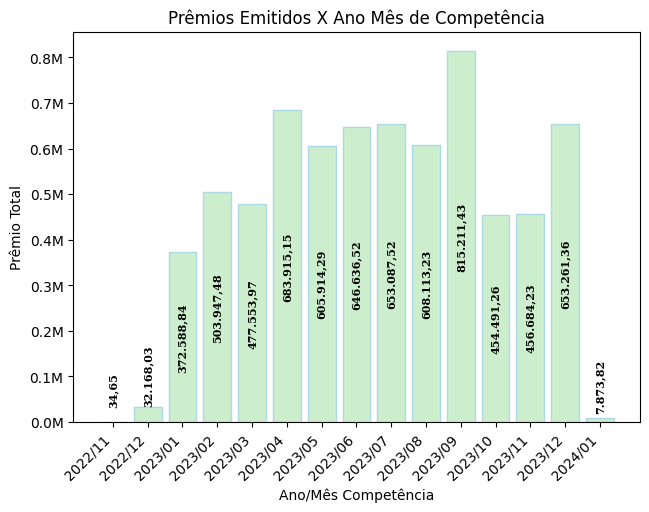

In [72]:
# Formata o eixo Y para mostrar valores em MIL(K)
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatador_milhao))

# Plota o gráfico de barras com os rótulos formatados
plt.bar(Vlr_Pre_totXComp.index, Vlr_Pre_totXComp.values, edgecolor=cor_borda, color=cor_preenchimento)

plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos em 45 graus e alinha à direita
plt.tight_layout()                   # Ajusta o layout para evitar cortes


# Configura o título e os rótulos dos eixos
plt.title('Prêmios Emitidos X Ano Mês de Competência' )
plt.xlabel('Ano/Mês Competência')
plt.ylabel('Prêmio Total')


for i, v in enumerate(Vlr_Pre_totXComp.values):
  if v <= 50000:
    offset = 70000
    plt.text(i, v+offset, formatador_financ(v),
             ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})
  else:
    plt.text(i, v/2,formatador_financ(v),
             ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})


# Exibe o gráfico
plt.show()

*Gráfico PRÊMIO X RAMO*

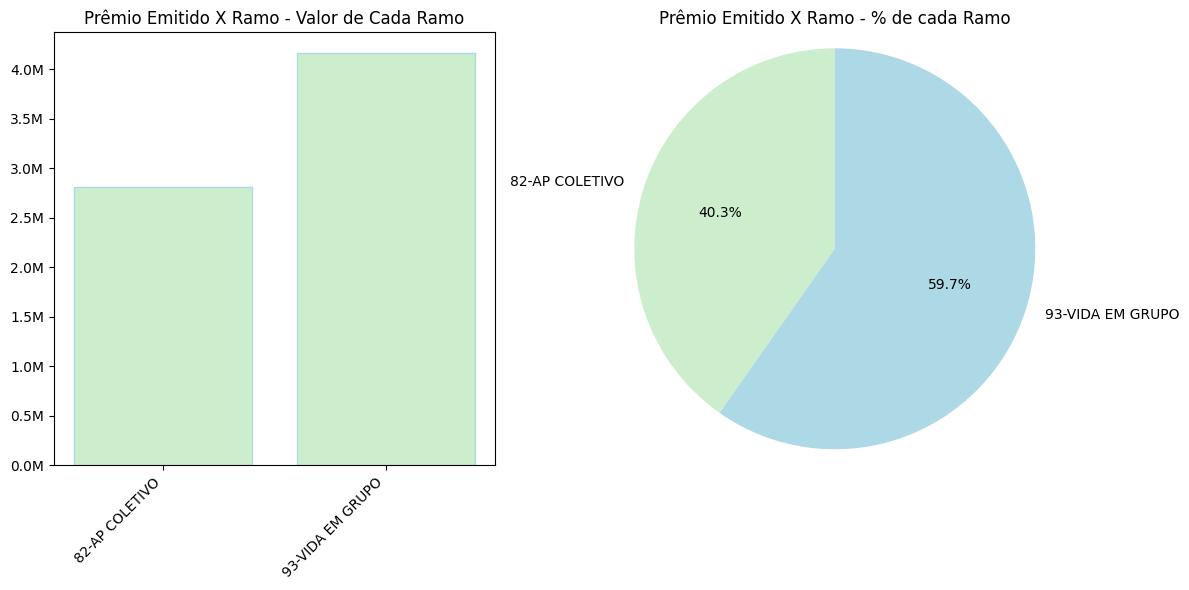

In [73]:

ramos = Vlr_Pre_totXRam.index
valores = Vlr_Pre_totXRam.values

# Cria a figura e os eixos para os dois gráficos
fig, (gr1, gr2) = plt.subplots(1, 2, figsize=(12, 6))

# Formata o eixo Y para mostrar valores em milhões
gr1.yaxis.set_major_formatter(FuncFormatter(formatador_milhao))

# Define as posições dos ticks (xticks)
gr1.set_xticks(range(len(ramos)))

# Gráfico de barras (gr1)
gr1.bar(ramos, valores, edgecolor=cor_borda, color=cor_preenchimento)
gr1.set_xticklabels(ramos, rotation=45, ha='right')
gr1.set_title('Prêmio Emitido X Ramo - Valor de Cada Ramo')

# Gráfico de pizza (gr2)
gr2.pie(valores, labels=ramos, autopct='%1.1f%%', startangle=90, colors =cores)
gr2.axis('equal')  # Assegura que o gráfico de pizza seja um círculo
gr2.set_title('Prêmio Emitido X Ramo - % de cada Ramo')

# Ajusta o layout e exibe os gráficos
plt.tight_layout()
plt.show()

*Gráfico Cancelamentos Emitidos X Competência*

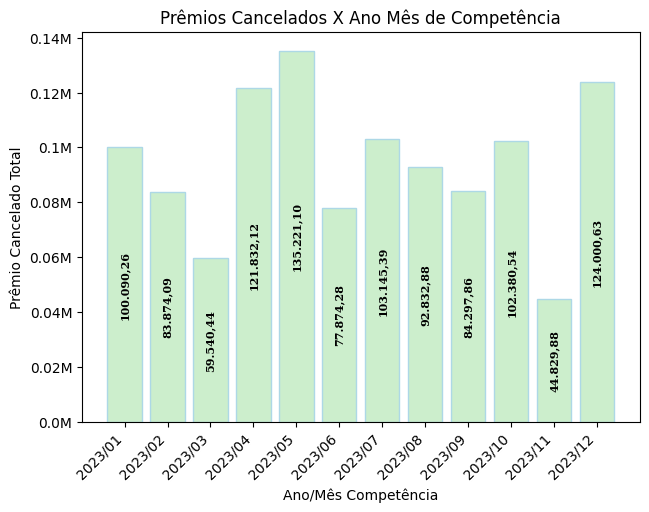

In [74]:
# Formata o eixo Y para mostrar valores em MIL(K)
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatador_milhao))

# Plota o gráfico de barras com os rótulos formatados
plt.bar(Vlr_Pre_totXCanc.index, Vlr_Pre_totXCanc.values, edgecolor=cor_borda, color=cor_preenchimento)

plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos em 45 graus e alinha à direita
plt.tight_layout()                   # Ajusta o layout para evitar cortes

# Define o título e os rótulos dos eixos

# Configura o título e os rótulos dos eixos
plt.title('Prêmios Cancelados X Ano Mês de Competência' )
plt.xlabel('Ano/Mês Competência')
plt.ylabel('Prêmio Cancelado Total')


for i, v in enumerate(Vlr_Pre_totXCanc.values):
  if v <= 1000:
    offset = 800000
    plt.text(i, v+offset, formatador_financ(v), ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})
  else:
    plt.text(i, v/2, formatador_financ(v), ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})


# Exibe o gráfico
plt.show()

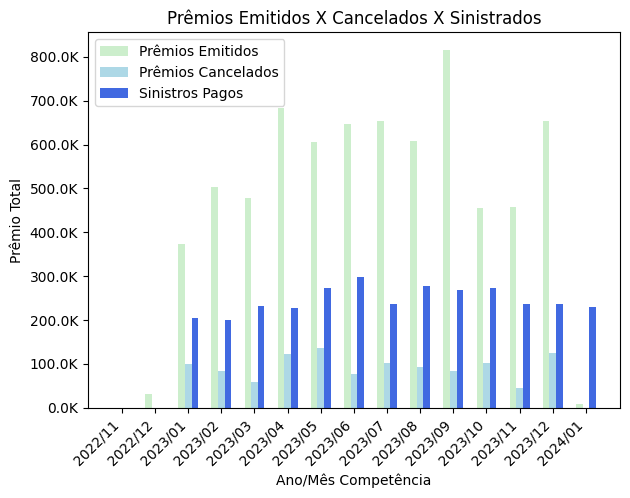

In [77]:
def formatador_milhao(x, pos):
    return f'{x/1000}K'

def formatador_financ(x):
    return f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')

# Defina a largura das barras
bar_width = 0.2

# Criando posições para as barras no eixo x
index = range(len(df_emXCancXSin))

# Plotando as barras para 'VLR_PRE_TOT_x'
plt.bar([i for i in index], df_emXCancXSin['VLR_PRE_TOT_x'], width=bar_width, label='Prêmios Emitidos',
        color=cor_base1)

# Plotando as barras para 'VLR_PRE_TOT_y', deslocadas para a direita
plt.bar([i + bar_width for i in index], df_emXCancXSin['VLR_PRE_TOT_y'], width=bar_width, label='Prêmios Cancelados',
        color =cor_base2)

# Plotando as barras para 'VLR_PGTO', deslocadas para a direita
plt.bar([i + bar_width + bar_width for i in index], df_emXCancXSin['VLR_PGTO'], width=bar_width, label='Sinistros Pagos',
        color =cor_base3)

# Formata o eixo Y para mostrar valores em milhões
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatador_milhao))

# Configura o título e os rótulos dos eixos
plt.title('Prêmios Emitidos X Cancelados X Sinistrados')
plt.xlabel('Ano/Mês Competência')
plt.ylabel('Valores Totais')

plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos em 45 graus e alinha à direita
plt.tight_layout()  # Ajusta o layout para evitar cortes

# Formata os rótulos do eixo X para "AAAA-MM"
rotulos_formatados = [f"{r[:4]}-{r[4:]}" for r in Vlr_Pre_totXCanc.index]

plt.xticks([i + bar_width for i in index], df_emXCancXSin.index) # Ajustando os rótulos do eixo x
# Adicione rótulos aos eixos
plt.xlabel('Ano/Mês Competência')
plt.ylabel('Prêmio Total')
plt.legend()
plt.show()

*Gráfico de Distribuição de Idades para os Seguros de Vida e Acidentes Pessoais*

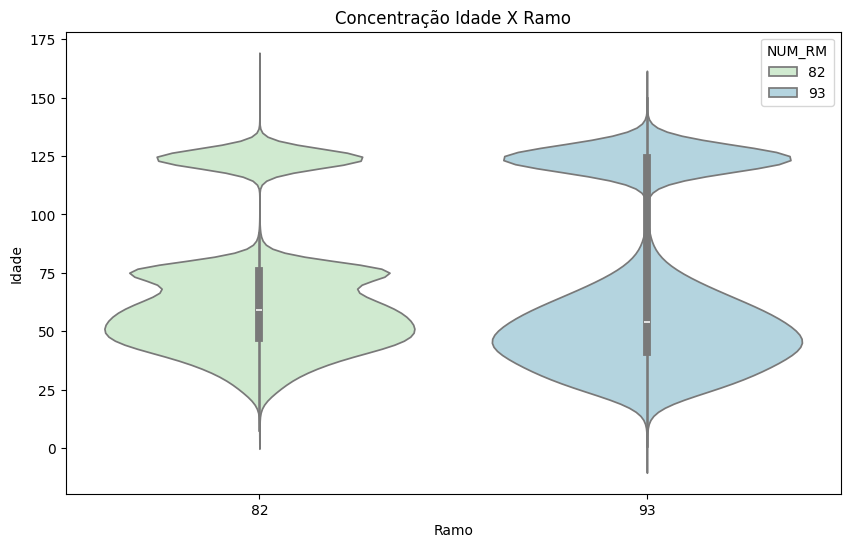

In [ ]:
cores_escolhidas = [cor_base1, cor_base2]

# Cria o violinplot com o parâmetro 'order'
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_pp_ft, x='NUM_RM', y='IDADE', hue='NUM_RM', palette=cores_escolhidas)
plt.title('Concentração Idade X Ramo')
plt.xlabel('Ramo')
plt.ylabel('Idade')
plt.show()



*Gráfico Prêmio X Idade*

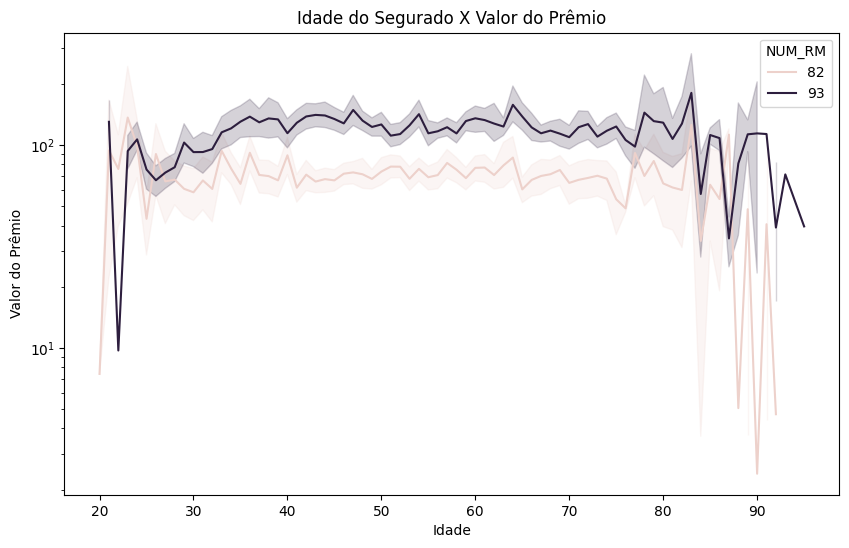

In [ ]:
# Para geração deste gráfico, vamos selecionar uma faixa de idade compatível
# Idade >=20 e Idade <=99
filtro = (df_pp_ft['IDADE'] >= 20) & (df_pp_ft['IDADE'] <= 99)

df_filtrado = df_pp_ft[filtro]
plt.figure(figsize=(10, 6))
sns.lineplot(x='IDADE',y='VLR_PRE_TOT',data=df_filtrado, hue = 'NUM_RM')

plt.title('Idade do Segurado X Valor do Prêmio')
plt.xlabel('Idade')
plt.ylabel('Valor do Prêmio')
plt.yscale('log')
plt.show()

*Gráfico Idade X Valor do Prêmio X Sexo*

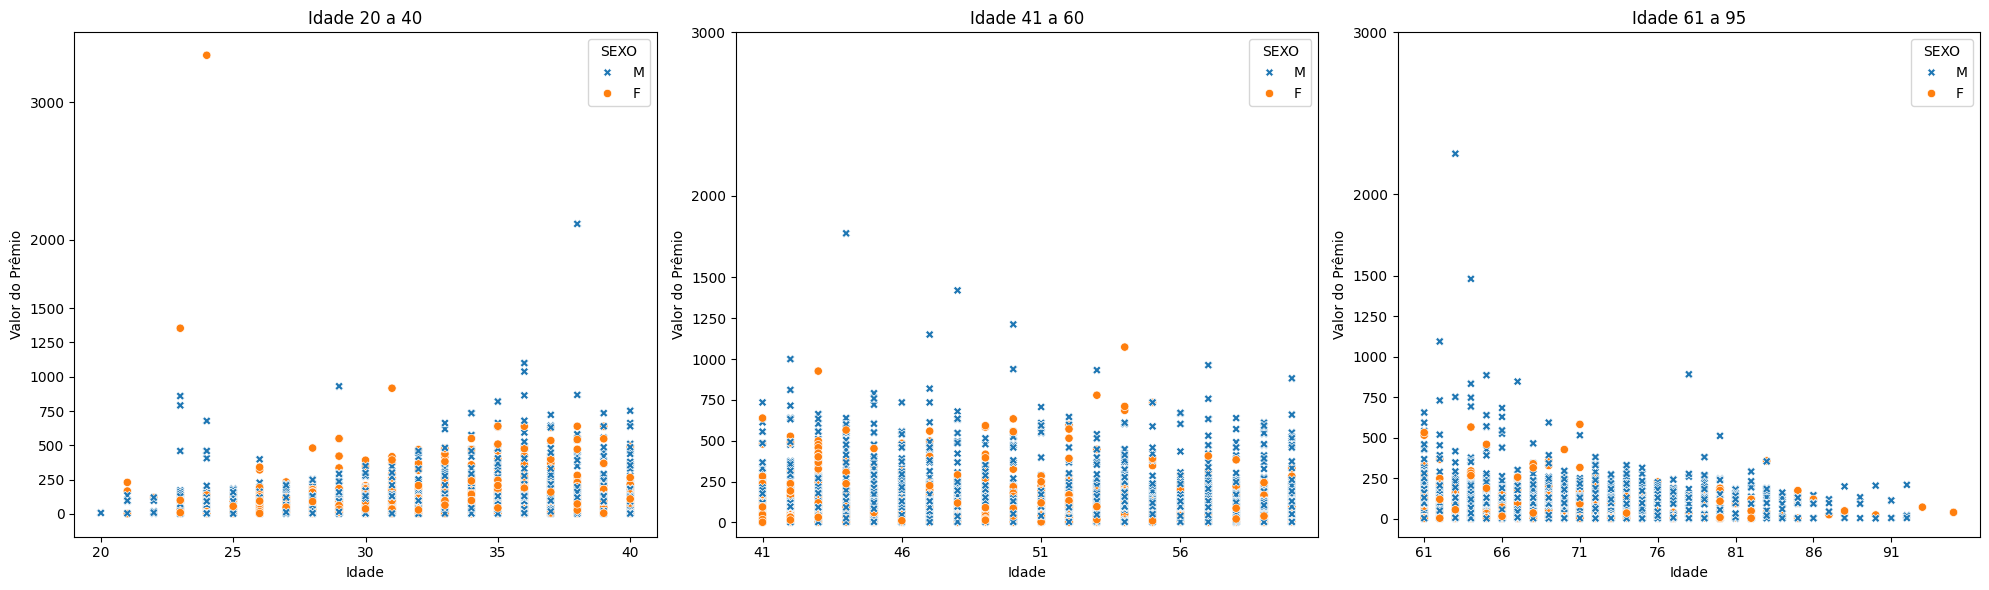

In [ ]:
# Para melhor análise, separamos a idade entre
# 20 - 40
# 41 - 60
# 61 - 95

faixas_idade = [(20, 40), (41, 60), (61, 95)]
eixo_y = [0, 250, 500, 750, 1000, 1250, 1500, 2000, 3000]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (idade_min, idade_max) in enumerate(faixas_idade):
  filtro = (df_pp_ft['IDADE'] >= idade_min) & (df_pp_ft['IDADE'] <= idade_max)

  df_filtrado = df_pp_ft[filtro]

  sns.scatterplot(x='IDADE', y='VLR_PRE_TOT', data=df_filtrado, hue='SEXO', style='SEXO', markers={'M': 'X', 'F': 'o'}, ax=axes[i])
  axes[i].set_xticks(range(idade_min, idade_max + 1, 5))
  axes[i].set_title(f'Idade {idade_min} a {idade_max}')
  axes[i].set_yticks(eixo_y)
  axes[i].set_ylabel('Valor do Prêmio')
  axes[i].set_xlabel('Idade')

plt.tight_layout()
plt.show()


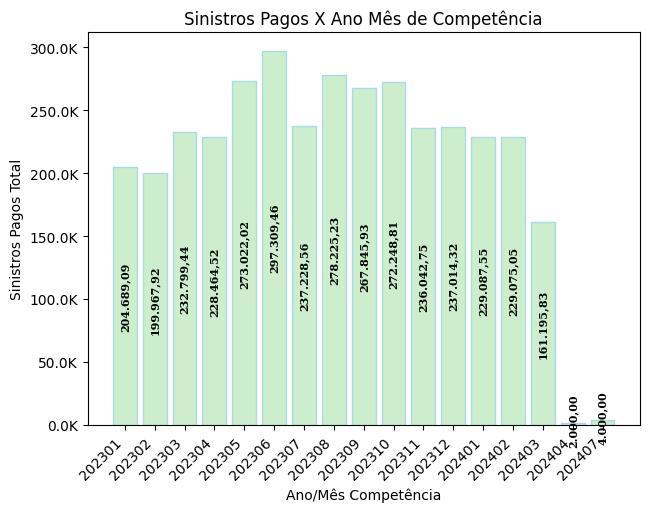

In [ ]:
# Sinistros Pagos por Competência
# Converte os rótulos de AM_COMP para o formato "AAAA-MM"
rotulos_formatados = [f"{r[:4]}-{r[4:]}" for r in Vlr_Pre_totXComp.index]

# Função para formatar os valores
def formatador_milhao(x, pos):
    return f'{x/1000}K'

def formatador_financ(x):
    return f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')

# Formata o eixo Y para mostrar valores em MIL(K)
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatador_milhao))

# Plota o gráfico de barras com os rótulos formatados
plt.bar(Vlr_Pre_pagXComp.index, Vlr_Pre_pagXComp.values, edgecolor=cor_borda, color=cor_preenchimento)

plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos em 45 graus e alinha à direita
plt.tight_layout()                   # Ajusta o layout para evitar cortes

# Define o título e os rótulos dos eixos

# Configura o título e os rótulos dos eixos
plt.title('Sinistros Pagos X Ano Mês de Competência' )
plt.xlabel('Ano/Mês Competência')
plt.ylabel('Sinistros Pagos Total')


for i, v in enumerate(Vlr_Pre_pagXComp.values):
  if v <= 5000:
    offset = 2000
    plt.text(i, v+offset, formatador_financ(v),
             ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})
  else:
    plt.text(i, v/2,formatador_financ(v),
             ha='center', va='center', color=cor_letra, rotation=90,
             fontdict={'fontsize': 8, 'fontweight': 'bold', 'fontfamily': 'serif'})


# Exibe o gráfico
plt.show()

==============================================================================================================